<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/04_Recurrent_Neural_Networks.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Neural Networks - Recurrent Neural Networks

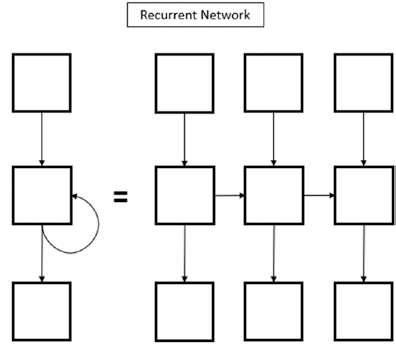

The difference in the RNN block is that there is a feedback loop. Where each input of a fully connected network is completely
independent, the inputs of an RNN have a feedback relation with each other. This makes the model good to fit data that has sequences, like Times series or written text.
Due to this architecture difference, there is not just one input in each unit, but there are two:

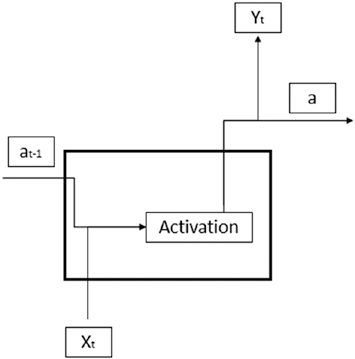

Also, the tanh activation layer is the most common for RNN instead of the ReLU. The reason for this is that for long sequences, the ReLU layer suffers from the exploding gradient problem: the repeated multiplication with weights is acting like an exponentiation that
makes it explode. The tanh activation layer does not have this problem, as the values are forced to stay between -1 and 1.

#### 1 - Importing Data

Data: Jena Climate dataset

Period of Record: From 2009 to 2016

Number of observations: 420551
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYMMDD hh:mm:ss format
2.   co2 - CO2 Concentration in  ppmv


The data returned by load_pandas contains the dates as the index.

Source: https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip.

In [13]:
import keras
import pandas as pd
from zipfile import ZipFile
import os
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
del zip_file
df = df.drop('Date Time', axis=1)
cols = ['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
'H2OC', 'rho', 'wv', 'mwv', 'wd']
df.columns = cols
df.head()


,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,mwv,wd
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### 2 - Data Preparation - Standardization, Sequence Data, Train and Test Sets

In this example, we’ll do a forecast of the temperature 12 hours later.
Now what we did in the fully connected model was to create lagged variables. There was one y variable (which was not lagged), and the independent variables were lagged values of the y variable and a lot of other variables. The first lag was at 72 time steps, so that the model would use the data from 12 hours ago to predict the now.

In the RNN, this is not what we should do, as the RNN learns sequences. A big jump of 72 time steps is not really respecting the sequential variation. Yet we do not just want to predict one time step later, as that would mean that we predict the temperature in 10 minutes from now. What we will do is create a matrix of y variables, with lags as well. Before, we wanted to predict one value 72 time steps into the future, but let’s model to predict each of those 72. This approach is called multistep forecasting.

Other than that, for this model we will use only the temperature data and not the other variables (in order to simplify the sequences construction)

In [14]:
df = df[['T']] ## Keep only temperature data

In [15]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

Then, we prepare the sequence data

In [16]:
ylist = list(df['T'])
n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period
X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]
  X_new.append(x_line)
  y_new.append(y_line)
  idx_start = idx_start - 1

# converting list of lists to numpy array
import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)

#### 3 - Data Preparation - Scaling and Standardization

A neural network will not be able to learn if you do not standardize the input data. Standardizing means getting the data onto the same scale. As an example, we will use the MinMax scaler.
MinMax scaler brings a variable into the range of 0–1 by
subtracting the variable’s minimum from each value and then
dividing it by the range of the variable.

In [ ]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

#### 4 - Data Preparation - Principal Component Analysis (PCA)

PCA allows to take a dataset with a large number of variables and
reduce the number of variables into a projection onto a number of dimensions. Those dimensions will contain the larger part of the information and will contain much less noise. The idea is to make new variables, called components, based on combinations of strongly correlated variables. The component is a linear combination of the original variables.
For example, Rain and Humidity may be correlated and it can be more interesting to use the combination rather than the original variables.

To fit a PCA, you generally start with a PCA with all the components

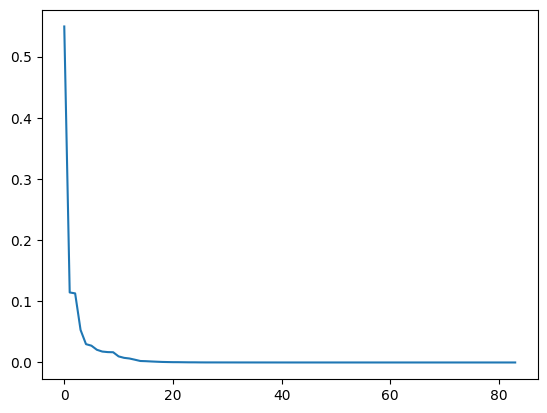

In [ ]:
# Fit a PCA with maximum number of components
from sklearn.decomposition import PCA
mypca = PCA()
mypca.fit(df)

# Make a scree plot
import matplotlib.pyplot as plt
plt.plot(mypca.explained_variance_ratio_)
plt.show()

In this plot, the x-axis shows the components from the first component to the last. The y variable shows the amount of variation that is captured in those components. The first five to ten components have much more information in them
than the higher components (those more to the right). For this reason, we retain 10 component rather than over 80

In [ ]:
mypca = PCA(10)
df = mypca.fit_transform(df)

#### 5 - The Neural Network With Keras

A general great first start is to start with a relatively simple network and work your way up from there. In this case, let’s start with a network using two dense layers with 64 nodes. That would make the architecture look as follows:

*   Optimizer: Adam
*   Learning rate: 0.01
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 10



Train-Test split



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33,
random_state=42)

Building the model using the keras library

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
random.seed(42)
simple_model = Sequential([
Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
Dense(64, activation='relu'),
Dense(1),
])
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [ ]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)

Fit the model (this step can take long time to complete). In this case, the result is not completeley reproducible due to the randomness

In [ ]:
smod_history = simple_model.fit(X_train, y_train,
validation_split=0.2,
epochs=10,
batch_size=32,
shuffle = True
)

Epoch 1/10
7042/7042 [==============================] - 12s 2ms/step - loss: 2.5920 - mean_absolute_error: 2.5920 - val_loss: 2.4787 - val_mean_absolute_error: 2.4787
Epoch 2/10
7042/7042 [==============================] - 11s 2ms/step - loss: 2.4846 - mean_absolute_error: 2.4846 - val_loss: 2.4945 - val_mean_absolute_error: 2.4945
Epoch 3/10
7042/7042 [==============================] - 10s 1ms/step - loss: 2.4573 - mean_absolute_error: 2.4573 - val_loss: 2.4372 - val_mean_absolute_error: 2.4372
Epoch 4/10
7042/7042 [==============================] - 11s 2ms/step - loss: 2.4434 - mean_absolute_error: 2.4434 - val_loss: 2.4164 - val_mean_absolute_error: 2.4164
Epoch 5/10
7042/7042 [==============================] - 10s 1ms/step - loss: 2.4314 - mean_absolute_error: 2.4314 - val_loss: 2.4423 - val_mean_absolute_error: 2.4423
Epoch 6/10
7042/7042 [==============================] - 13s 2ms/step - loss: 2.4239 - mean_absolute_error: 2.4239 - val_loss: 2.4230 - val_mean_absolute_error: 2.423

Plot the training history

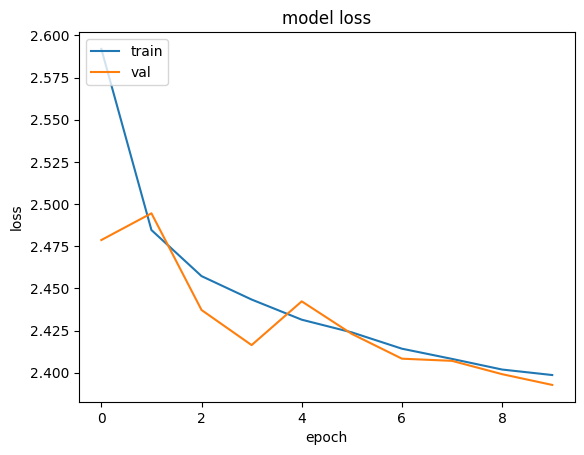

In [ ]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Ideally, we would find a curve that decrease the while the epochs increase (leftmost figure), like the one that we had in the previous run.
In most case, we can find results that are overfitting data (central figure) or not learning (rightmost figure):
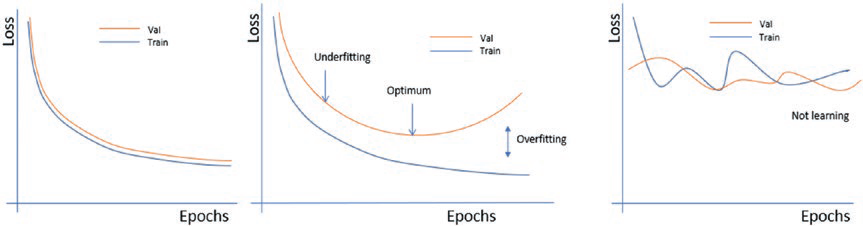

Finally, we plot predicted data vs test set

In [ ]:
from sklearn.metrics import r2_score
preds = simple_model.predict(X_test)
print(r2_score(preds, y_test))


4336/4336 [==============================] - 3s 802us/step
0.8474848946978979
